# Imports

In [1]:
from datetime import datetime
import pandas as pd

from diive.core.io.files import load_parquet, save_parquet
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS

# Load data

In [2]:
df = load_parquet(filepath="52.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023.parquet")
# df = df.loc[(df.index.year >= 2021) & (df.index.year <= 2023)].copy()
df

Loaded .parquet file 52.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023.parquet (0.666 seconds). Detected time resolution of <30 * Minutes> / 30min 


,AIR_MV,AIR_DENSITY,AIR_RHO_CP,AIR_CP,AOA_METHOD,AXES_ROTATION_METHOD,...,TS_GF1_0.04_1_gfXG,FLAG_TS_GF1_0.04_1_gfXG_ISFILLED,TS_GF1_0.15_1_gfXG,FLAG_TS_GF1_0.15_1_gfXG_ISFILLED,TS_GF1_0.4_1_gfXG,FLAG_TS_GF1_0.4_1_gfXG_ISFILLED
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.731083,1,3.657870,1,4.407055,1
2005-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.731083,1,3.657870,1,4.407055,1
2005-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.968712,1,3.575649,1,4.406270,1
2005-01-01 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.968712,1,3.565512,1,4.357224,1
2005-01-01 02:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.817249,1,3.753684,1,4.440534,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0.023667,1.22060,1231.56,1008.98,0.0,1.0,...,3.359719,0,4.942291,0,6.010860,0
2023-12-31 22:15:00,0.023709,1.21833,1229.43,1009.11,0.0,1.0,...,3.220912,0,4.944976,0,6.011540,0
2023-12-31 22:45:00,0.023718,1.21785,1228.93,1009.10,0.0,1.0,...,3.148644,0,4.941619,0,6.014273,0


# Gap-filling `SWC_GF1_0.15_1` (most complete SWC variable)

In [3]:
df[['SWC_GF1_0.05_1', 'SWC_GF1_0.15_1', 'SWC_GF1_0.75_1']].resample('A').count()

C:\Users\holukas\AppData\Local\Temp\ipykernel_18896\320009507.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df[['SWC_GF1_0.05_1', 'SWC_GF1_0.15_1', 'SWC_GF1_0.75_1']].resample('A').count()


,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.75_1
TIMESTAMP_MIDDLE,,,
2005-12-31,3213,3213,3213
2006-12-31,17452,17428,17434
2007-12-31,17501,17503,17502
2008-12-31,17560,17554,17558
2009-12-31,17504,17505,17506
2010-12-31,10879,16539,16536
2011-12-31,17021,17018,17013
2012-12-31,17267,17268,17267
2013-12-31,17513,17512,17514


In [4]:
[print(c) for c in df if "SWC" in c];
[print(c) for c in df if "PREC" in c];

SWC_GF1_0.05_1
SWC_GF1_0.15_1
SWC_GF1_0.75_1
PREC_RAIN_TOT_GF1_0.5_1
FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED
FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED
TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1



Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.

Feature reduction based on permutation importance ...
[0]	validation_0-rmse:4.24619	validation_1-rmse:4.24619
[1]	validation_0-rmse:3.57644	validation_1-rmse:3.57644
[2]	validation_0-rmse:3.07415	validation_1-rmse:3.07415
[3]	validation_0-rmse:2.76569	validation_1-rmse:2.76569
[4]	validation_0-rmse:2.55242	validation_1-rmse:2.55242
[5]	validation_0-rmse:2.40355	validation_1-rmse:2.40355
[6]	validation_0-rmse:2.26818	validation_1-rmse:2.26818
[7]	validation_0-rmse:2.16471	validation_1-rmse:2.16471
[8]	validation_0-rmse:2.09313	validation_1-rmse:2.09313
[9]	validation_0-rmse:2.00409	validation_1-rmse:2.00409
[10]	validation_0-rmse:1.85594	validation_1-rmse:1.85594
[11]	validation_0-rmse:1.81737	validation_1-rmse:1.81737
[12]	validation_0-rmse:1.76822	

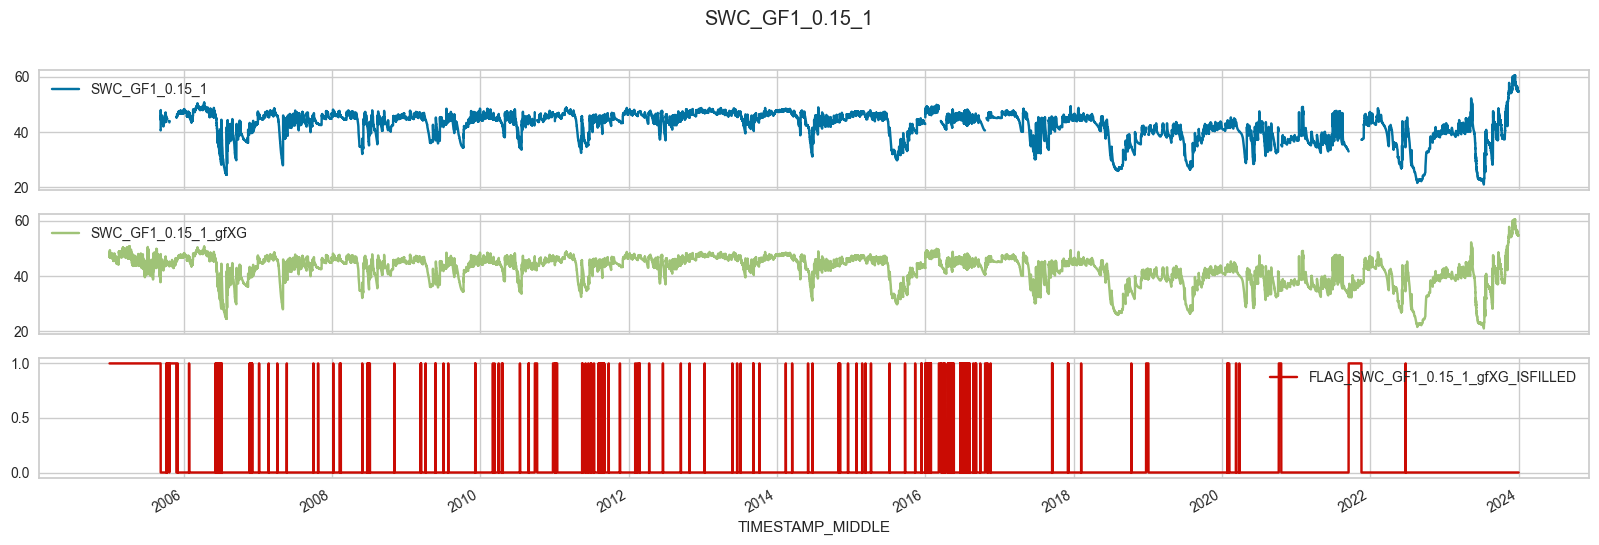

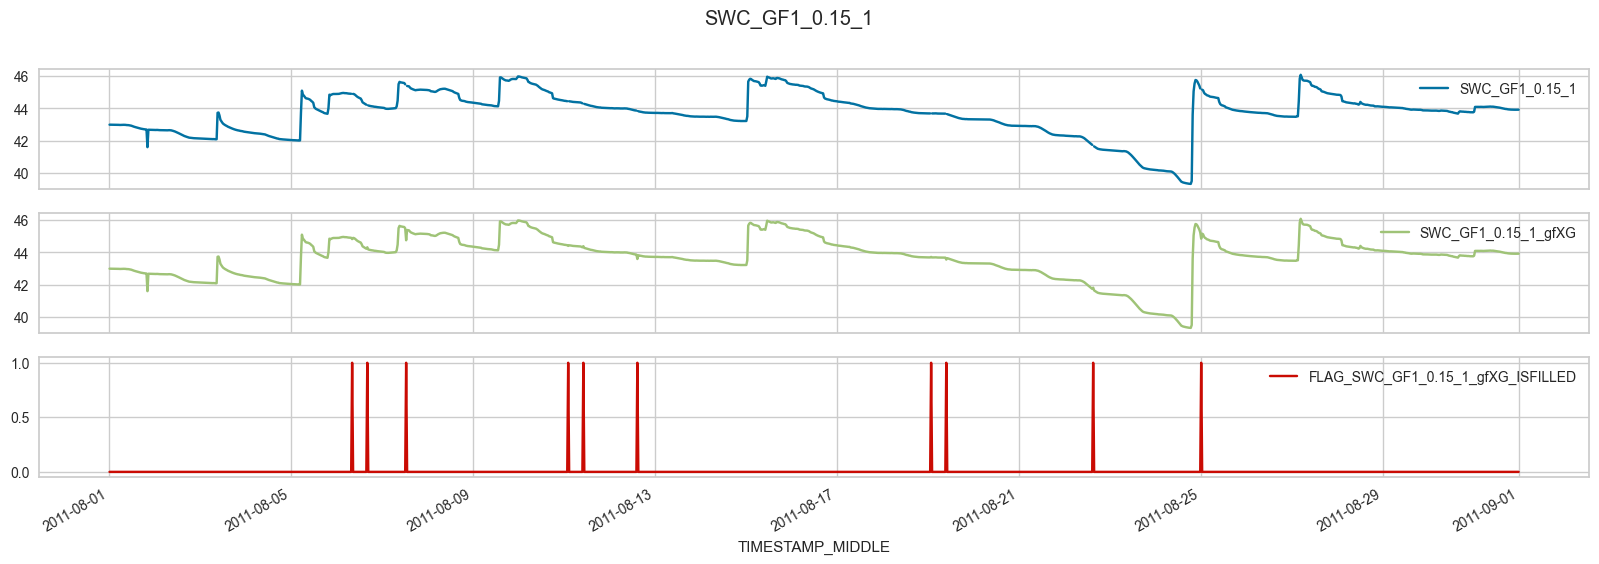

In [5]:
TARGET_COL = 'SWC_GF1_0.15_1'
TARGET_GAPFILLED_COL = f'{TARGET_COL}_gfXG'
FLAG_GAPFILLED_COL = f'FLAG_{TARGET_GAPFILLED_COL}_ISFILLED'

# Dataframe for gap-filling
_df = pd.DataFrame()
_df[TARGET_COL] = df[TARGET_COL].copy()
_df['PREC_RAIN_TOT_GF1_0.5_1'] = df['PREC_RAIN_TOT_GF1_0.5_1'].copy()
_df['TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1'] = df['TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1'].copy()

# XGBoost
xgb = XGBoostTS(
    input_df=_df,
    target_col=TARGET_COL,
    features_lag=[-5, -1],
    features_lag_exclude_cols=['TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1'],
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb.reduce_features()
xgb.report_feature_reduction()
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()
results = xgb.gapfilling_df_

# Add results to main data
df = pd.concat([df, results[[TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]]], axis=1)

# Plot
plotdf = df[[TARGET_COL, TARGET_GAPFILLED_COL, FLAG_GAPFILLED_COL]].copy()
plotdf.plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));
locs = (plotdf.index.year == 2011) & (plotdf.index.month == 8)
plotdf[locs].plot(x_compat=True, title=TARGET_COL, subplots=True, figsize=(20, 6));

# Save to file

In [6]:
OUTNAME = "53.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023"
filepath = save_parquet(filename=OUTNAME, data=df)
df.to_csv(f"{OUTNAME}.csv")

Saved file 53.1_CH-CHA_IRGA-L4.1+QCL-L1+LGR-L1+M10+MGMT_2005-2023.parquet (6.397 seconds).


# **End of notebook**.

In [7]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-12-16 15:54:55
